# Import library and support function

In [97]:
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm 
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader
import json
import os
from datasets import load_dataset
import torch_geometric.data 
import data
from collections import Counter
import pandas as pd
import numpy as np
import torch.nn as nn
from torch_geometric.data import Data
from sklearn.metrics import (ConfusionMatrixDisplay, roc_auc_score, precision_score, average_precision_score, recall_score,f1_score, accuracy_score,mean_squared_error,mean_absolute_error, roc_curve, auc, classification_report,auc,confusion_matrix,matthews_corrcoef)
from sklearn.model_selection import train_test_split
from torch_geometric.nn import GATConv
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch_geometric.nn import global_add_pool
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import time

In [98]:
with open("X_matrix_final.json",'r') as f:
    SEMANTIC_EMBEDDING = json.load(f)
    
with open("w2v_matrix_final.json",'r') as f:
    W2V_EMBEDDING = json.load(f)
# Model hyperparameters
EPOCH_LIST = [200]          
BATCH_LIST = [256] 
SEMANTIC_EMBEDDING_DIMENSION = 768
W2V_EMBEDDING_DIM = 100
HIDDEN_DIM = 12
NUM_HEADS = 12
OUTPUT_DIM = 1
# TRAIN_EPOCHS = 100
LEARNING_RATE = 1e-4
# BATCH_SIZE = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Result
RESULT_PATH = "Results/test.csv"
CHART_PATH = "Results/Charts04"
res_df = pd.DataFrame(columns=[
    "Data Type",
    "Baseline",
    "STT",
    "Train Epochs",
    "Batch Size",
    "Result Type",
    "Loss Train",
    "Loss Validation",
    "Accuracy",
    "Precision",
    "Recall",
    "F1-Score",
    "TNR",
    "Confusion Matrix",
    "Training Time",
    "Testing Time"
])
res_df.to_csv(RESULT_PATH, mode='a', header=not os.path.exists(RESULT_PATH), index=False)

# Loss
# EPOCHS_LOSS = []

In [99]:
STRUCTURAL_INPUT_DIM = 1 

def API_seq_to_graph_StructuralOnly(api_sequence, label):    
    api_sequence = [api for api in api_sequence if isinstance(api, str) and api]
    if len(api_sequence) < 2:
        return None
    unique_apis = list(set(api_sequence))
    number_nodes = len(unique_apis)
    apis_call_time = {api: idx for idx, api in enumerate(unique_apis)}
    nodes_features = np.ones((number_nodes, STRUCTURAL_INPUT_DIM), dtype=np.float32)
    
    X = torch.tensor(nodes_features, dtype=torch.float32)
    y = torch.tensor(label, dtype=torch.float32)

    transitions = [(api_sequence[i], api_sequence[i+1]) for i in range(len(api_sequence) - 1)]
    edge_counters = Counter(transitions)

    src, dst, edge_weights = [], [], []
    for (u, v), count in edge_counters.items():
        src.append(apis_call_time[u])
        dst.append(apis_call_time[v])
        edge_weights.append(count)

    edge_index = torch.tensor([src, dst], dtype=torch.long)
    
    edge_attr = torch.tensor(edge_weights, dtype=torch.float).view(-1, 1)
    return Data(x=X, edge_index=edge_index, edge_attr=edge_attr, y=y, num_nodes=number_nodes)

In [100]:
# FUNCTION - API SEQUENCE TO GRAPH
def API_seq_to_graph(api_sequence, label, feature_type):
    api_sequence = [api for api in api_sequence if isinstance(api, str) and api]
    if len(api_sequence) < 2:
        return None

    # Graph edges
    transitions = [(api_sequence[i], api_sequence[i+1]) for i in range(len(api_sequence)-1)]
    edge_counters = Counter(transitions)

    unique_apis = list(set(api_sequence))
    apis_call_time = {api: idx for idx, api in enumerate(unique_apis)}
    number_nodes = len(unique_apis)

    src, dst, edge_weights = [], [], []
    for (u, v), count in edge_counters.items():
        src.append(apis_call_time[u])
        dst.append(apis_call_time[v])
        edge_weights.append(count)

    edge_index = torch.tensor([src, dst], dtype=torch.long)
    edge_attr = torch.tensor(edge_weights, dtype=torch.float).view(-1,1)

    # Node features
    nodes_features = []
    if feature_type == 'BERT':
        source = SEMANTIC_EMBEDDING
        current_dim = SEMANTIC_EMBEDDING_DIMENSION 
    elif feature_type == 'W2V':
        source = W2V_EMBEDDING
        current_dim = W2V_EMBEDDING_DIM 
    else:
        raise ValueError("Feature type not supported")
    for api in unique_apis:
        embedding = source.get(api)
        if embedding is None:
            nodes_features.append(np.zeros(current_dim))
        else:
            nodes_features.append(embedding)
    
    nodes_features = np.array(nodes_features)
    
    X = torch.tensor(nodes_features, dtype=torch.float32)
    y = torch.tensor(label, dtype=torch.float32)

    return Data(x=X, edge_index=edge_index, edge_attr=edge_attr, y=y, num_nodes=number_nodes)


In [101]:
# def API_seq_to_tensor(api_sequence: List[str], label: float, max_len: int = MAX_LENGTH, input_dim: int = INPUT_DIM) -> Tuple[torch.Tensor, torch.Tensor] | None:  
#     # 1. Lọc và kiểm tra độ dài
#     api_sequence = [api for api in api_sequence if isinstance(api, str) and api]
#     if not api_sequence:
#         return None

#     nodes_features = []
    
#     # 2. Tra cứu Vector Nhúng (Embedding Lookup)
#     for api in api_sequence:
#         embedding = SEMANTIC_EMBEDDING.get(api)
#         if embedding is None:
#             # Nếu không tìm thấy, gán vector không để giữ kích thước
#             nodes_features.append(np.zeros(input_dim, dtype=np.float32))
#         else:
#             nodes_features.append(np.array(embedding, dtype=np.float32))

#     # Chuyển đổi thành NumPy array để dễ dàng thao tác padding/truncation
#     features_array = np.array(nodes_features)
#     current_length = features_array.shape[0]

#     # 3. Truncation (Cắt bớt nếu chuỗi quá dài)
#     if current_length > max_len:
#         # Cắt bớt từ cuối chuỗi
#         features_array = features_array[:max_len, :]
#         current_length = max_len
    
#     # 4. Zero-Padding (Thêm số 0 nếu chuỗi quá ngắn)
#     if current_length < max_len:
#         # Tạo ma trận zero để padding
#         padding_needed = max_len - current_length
#         zero_padding = np.zeros((padding_needed, input_dim), dtype=np.float32)
#         features_array = np.vstack([features_array, zero_padding])
        
#     # 5. Chuyển đổi sang Tensor PyTorch
#     X = torch.tensor(features_array, dtype=torch.float32)
#     y = torch.tensor([label], dtype=torch.float32) # Nhãn là Tensor 1 chiều

#     # Kích thước X: [MAX_LENGTH, INPUT_DIM] -> [100, 768]
#     return X, y

In [102]:
class GCN(nn.Module):
    def __init__(self, input_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, HIDDEN_DIM)
        self.conv2 = GCNConv(HIDDEN_DIM, HIDDEN_DIM)

        self.classifier = nn.Sequential(
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM//2),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM//2, OUTPUT_DIM)
        )

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = x.float()
        
        # GCN
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        
        # SUM POOLING
        x = global_add_pool(x, batch)
        
        # MLP Classifier
        x = self.classifier(x)
        return torch.sigmoid(x).squeeze(1)

In [103]:
from torch_geometric.nn import GINConv

class GINConv_Layer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        # GINConv sử dụng một MLP bên trong để tổng hợp thông điệp
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.ReLU(),
            nn.Linear(output_dim, output_dim)
        )
        self.conv = GINConv(self.mlp, train_eps=True) # train_eps=True để học hệ số epsilon

    def forward(self, x, edge_index):
        return self.conv(x, edge_index)

class GIN_Structural(nn.Module):
    def __init__(self, input_dim): # input_dim sẽ là 1
        super(GIN_Structural, self).__init__()
        
        self.conv1 = GINConv_Layer(input_dim, HIDDEN_DIM)
        self.conv2 = GINConv_Layer(HIDDEN_DIM, HIDDEN_DIM)

        self.classifier = nn.Sequential(
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM//2),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM//2, OUTPUT_DIM)
        )

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = x.float()
        
        # GIN
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        
        # SUM POOLING (GIN thường sử dụng Global Sum Pooling)
        x = global_add_pool(x, batch)
        
        # MLP Classifier
        x = self.classifier(x)
        return torch.sigmoid(x).squeeze(1)

In [104]:
class DawnGNN_GAT(nn.Module):
    def __init__(self, input_dim):
        
        super(DawnGNN_GAT, self).__init__()
        self.conv1 = GATConv(input_dim, HIDDEN_DIM, heads=NUM_HEADS, dropout=0.6)
        self.conv2 = GATConv(HIDDEN_DIM * NUM_HEADS, HIDDEN_DIM, heads=1, concat=False, dropout=0.6)

        self.classifier = nn.Sequential(
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM//2),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM//2, OUTPUT_DIM)
        )

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # GAT
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))

        # SUM POOLING
        x = global_add_pool(x, batch)

        # MLP Classifier
        x = self.classifier(x)
        return torch.sigmoid(x).squeeze(1)
        # x = self.classifier(x)
        # print("Logits (trước Sigmoid):", x) 
    
        # final_output = torch.sigmoid(x).squeeze(1)
        
        # # In ra xác suất cuối cùng
        # print("Xác suất cuối cùng (sau Sigmoid):", final_output) 
        
        # return final_output

In [105]:
class FeatureSum_LSTM(nn.Module):
    def __init__(self, input_dim):
        super(FeatureSum_LSTM, self).__init__()
        self.lstm_mock = nn.Sequential(
            nn.Linear(input_dim, HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM // 2)
        )
        
        # Final Classifier Head
        self.classifier = nn.Sequential(
            nn.Linear(HIDDEN_DIM // 2, OUTPUT_DIM)
        )
        
    def forward(self, data):
        x, batch = data.x, data.batch
        x = x.float()
        
        # SUM POOLING
        x = global_add_pool(x, batch)
        
        # LTSM MOCK
        x = self.lstm_mock(x)
        
        # MLP Classifier
        x = self.classifier(x)
        
        return torch.sigmoid(x).squeeze(1)

In [106]:
# EVALUATION FUNCTION
def evaluate_model(DATASET, name, epoch, model, loader, BATCH_SIZE, EPOCHS_LOSS, TRAIN_EPOCHS, device, criterion, val_test, training_time, train_loss_current, cumulative_testing_time=0):
    model.eval()
    start_test = time.time()
    total_loss = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            loss = criterion(out.float(), data.y.float())
            total_loss += loss.item() * data.num_graphs
            y_pred.extend((out>0.5).long().cpu().tolist())
            y_true.extend(data.y.long().cpu().tolist())

    end_test = time.time()
    testing_time = end_test - start_test
    cumulative_testing_time += testing_time
    precision = precision_score(y_true, y_pred, average='binary', zero_division=0)
    recall = recall_score(y_true, y_pred, average='binary', zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='binary', zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    TNR = tn / (tn + fp)
    FPR = fp / (fp + tn)
    FNR = fn / (fn + tp)
    NPV = tn / (tn + fn)

    if (val_test == 'Test'):
        LABELS = ['Benign', 'Malware']
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
        plt.title('Confusion Matrix', fontsize=17, pad=20)
        plt.ylabel('Actual', fontsize=13)
        plt.xlabel('Prediction', fontsize=13)
        plt.gca().xaxis.set_label_position('top') 
        plt.gca().xaxis.tick_top()
        plt.show()

    res_df.loc[len(res_df)] = [
        DATASET,
        name,
        epoch,
        TRAIN_EPOCHS,
        BATCH_SIZE,
        val_test,
        train_loss_current,
        total_loss/len(loader.dataset),
        acc,
        precision,
        recall,
        f1,
        TNR,
        str(cm.tolist()),
        training_time,
        cumulative_testing_time
    ]
    if ((epoch == TRAIN_EPOCHS) and (val_test == 'Test')):
        res_df.to_csv(RESULT_PATH, mode='a', header=False, index=False)

    avg_epoch_loss = total_loss/len(loader.dataset)
    EPOCHS_LOSS.append(avg_epoch_loss)

    return total_loss/len(loader.dataset), acc, f1, precision, recall, TNR, cumulative_testing_time


In [107]:
def run_experiment_baseline(feature_type, model_class, input_dim, name):
    print("==================== CONVERT API SEQUENCE TO GRAPH ====================")
    # LOAD DATASET
    # dataset = ["APIMDS", "MalBehavD-V1-dataset", "WINDOWS_PE_APICALLS"]
    dataset = ["MalBehavD-V1-dataset"]
    # Load Dataset
    for ds in dataset: 
        DATASET_PATH = f"../Dataset/{ds}.csv"
        DATASET = ds
        df = pd.read_csv(DATASET_PATH, low_memory=False)
        # print(df.head(5))
        if ds == 'MalBehavD-V1-dataset':
            start_api = 2
            label_col_name = 'labels'
        elif ds == 'APIMDS':
            start_api = 2
            label_col_name = 'labels'
        elif ds == 'WINDOWS_PE_APICALLS':
            start_api = 1
            df['labels'] = df['Malware'].apply(lambda x: 0 if x.lower() in ['benign', 'normal'] else 1)
            label_col_name = 'labels'
        elif ds == 'MalAnalysis_API_Call_Sequences':
            start_api = 3
            label_col_name = 'malware'
            
        # LABELS = df[label_col_name]
        # print(f"Label: {LABELS}")
        # print(df.head(5))
        data_list = []
        LABELS = []
        for index, row in tqdm(df.iterrows(), total=len(df)):
            api_sequence = row.iloc[start_api:].dropna().tolist()
            label = float(row[label_col_name])
            
            graph = API_seq_to_graph(api_sequence, label, feature_type=feature_type)
            # graph = API_seq_to_graph_StructuralOnly(api_sequence, label)
            if graph is not None:
                data_list.append(graph)
                LABELS.append(label)
    
        # Split dataset
        train_data, temp_data, train_labels, temp_labels = train_test_split(data_list, LABELS, test_size=0.2, random_state=42, stratify=LABELS)
        val_data, test_data, val_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels)
    
        # Model & optimizer
        model = model_class(input_dim=input_dim).to(DEVICE)
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
        # Training
        for epoch in EPOCH_LIST:
            for batch in BATCH_LIST:    
                TRAIN_EPOCHS = epoch
                BATCH_SIZE = batch
                EPOCHS_LOSS = []
                TRAIN_LOSS_HISTORY = []
    
                train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
                val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)
                test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

                
                print(f"\n===== RUNNING WITH EPOCH={epoch}  |  BATCH={batch} =====")
                cumulative_testing_time = 0
                for epoch in range(1, TRAIN_EPOCHS+1):
                    model.train()
                    start_train = time.time()
                    total_loss = 0
                    for data in train_loader:
                        optimizer.zero_grad()
                        data = data.to(DEVICE)
                        out = model(data)
                        loss = criterion(out.float(), data.y.float())
                        loss.backward()
                        optimizer.step()
                        total_loss += loss.item() * data.num_graphs
            
                    end_train = time.time()
                    training_time = end_train - start_train
                    train_loss_current = total_loss/len(train_data)
                    TRAIN_LOSS_HISTORY.append(train_loss_current)
                    
                    val_loss, val_acc, val_f1, val_pre, val_recall, val_TNR, cumulative_testing_time = evaluate_model(DATASET, name, epoch, model, val_loader, BATCH_SIZE, EPOCHS_LOSS, TRAIN_EPOCHS, DEVICE, criterion, val_test="Validation", training_time=training_time, train_loss_current=train_loss_current, cumulative_testing_time=cumulative_testing_time)
                    print(f"Epoch {epoch} | Train Loss: {total_loss/len(train_data):.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | Val Precision: {val_pre:.4f} | Val Recall: {val_recall:.4f} | Val TNR: {val_TNR:.4f}")
    
    
                plt.figure(figsize=(16,10))
                plt.plot(range(1, len(EPOCHS_LOSS)+1), EPOCHS_LOSS, marker='o', linestyle='-', label='Validation Loss', color='blue')
                plt.plot(range(1, len(TRAIN_LOSS_HISTORY)+1), TRAIN_LOSS_HISTORY, marker='x', linestyle='--', label='Training Loss', color='red')
                plt.title(f"Training and Validation Loss per Epoch for {name}", fontsize=15)
                plt.xlabel("Epoch", fontsize=13)
                plt.ylabel("Loss", fontsize=13)
                plt.grid(True)
                plt.legend()
                
                chart_path = f"{CHART_PATH}/{DATASET}_Baseline{name}_Loss_E{epoch}_B{batch}.png"
                plt.savefig(chart_path, dpi=300)    
                plt.show()
    
                print("==================== TESTING ====================")
                test_loss, test_acc, test_f1, test_precision, test_recall, test_TNR, cumulative_testing_time = evaluate_model(DATASET, name, epoch, model, test_loader, BATCH_SIZE, EPOCHS_LOSS, TRAIN_EPOCHS, DEVICE, criterion, val_test="Test", training_time=0, train_loss_current=0, cumulative_testing_time=0)
                print("\n=======================================================")
                print(f"✅ FINAL TEST PERFORMANCE (GAT Classifier):")
                print(f"Accuracy: {test_acc:.4f} | F1-Score: {test_f1:.4f} | Loss: {test_loss:.4f} | Recall: {test_recall:.4f} | Precision: {test_precision:.4f} | TNR: {test_TNR:.4f}")
                print("=======================================================")

            
    return model, test_loader, criterion

==================== TRAINING ====================
============ BASELINE 04: WORD2VEC + GIN ============
==================== CONVERT API SEQUENCE TO GRAPH ====================


100%|██████████| 2570/2570 [00:01<00:00, 1822.82it/s]



===== RUNNING WITH EPOCH=200  |  BATCH=256 =====
Epoch 1 | Train Loss: 0.7048 | Val Acc: 0.5058 | Val F1: 0.0305 | Val Precision: 1.0000 | Val Recall: 0.0155 | Val TNR: 1.0000
Epoch 2 | Train Loss: 0.6938 | Val Acc: 0.5253 | Val F1: 0.1029 | Val Precision: 1.0000 | Val Recall: 0.0543 | Val TNR: 1.0000
Epoch 3 | Train Loss: 0.6881 | Val Acc: 0.6304 | Val F1: 0.5366 | Val Precision: 0.7237 | Val Recall: 0.4264 | Val TNR: 0.8359
Epoch 4 | Train Loss: 0.6863 | Val Acc: 0.6498 | Val F1: 0.6642 | Val Precision: 0.6403 | Val Recall: 0.6899 | Val TNR: 0.6094
Epoch 5 | Train Loss: 0.6848 | Val Acc: 0.6265 | Val F1: 0.6943 | Val Precision: 0.5892 | Val Recall: 0.8450 | Val TNR: 0.4062
Epoch 6 | Train Loss: 0.6830 | Val Acc: 0.6926 | Val F1: 0.7106 | Val Precision: 0.6736 | Val Recall: 0.7519 | Val TNR: 0.6328
Epoch 7 | Train Loss: 0.6809 | Val Acc: 0.6809 | Val F1: 0.7230 | Val Precision: 0.6407 | Val Recall: 0.8295 | Val TNR: 0.5312
Epoch 8 | Train Loss: 0.6791 | Val Acc: 0.6576 | Val F1: 0.71

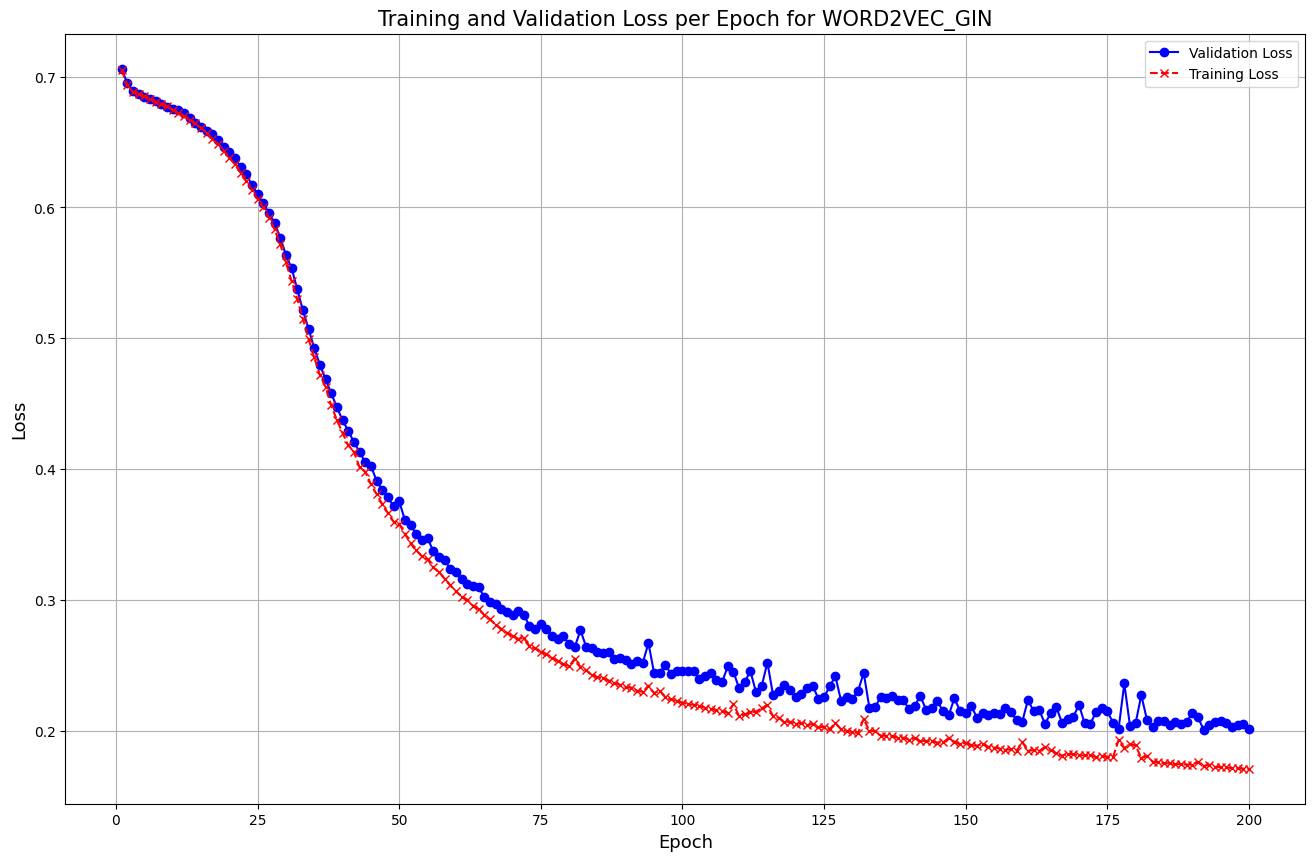

==================== TESTING ====================


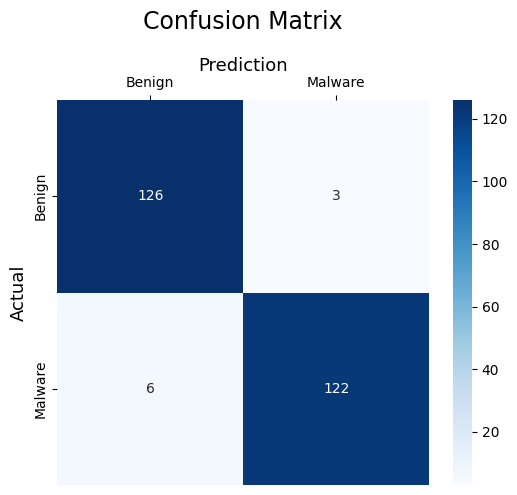


✅ FINAL TEST PERFORMANCE (GAT Classifier):
Accuracy: 0.9650 | F1-Score: 0.9644 | Loss: 0.1218 | Recall: 0.9531 | Precision: 0.9760 | TNR: 0.9767


In [108]:
print("==================== TRAINING ====================")
if __name__ == '__main__':
    STRUCTURAL_INPUT_DIM = 1
    # 1. Word2Vec + GCN
    # print("============ BASELINE 01: WORD2VEC + GCN ============")
    # model, test_loader, criterion = run_experiment_baseline('W2V', GCN, W2V_EMBEDDING_DIM, 'WORD2VEC_GCN')
    
    # # 2. Word2Vec + LSTM
    # print("============ BASELINE 02: WORD2VEC + LSTM ============")
    # model, test_loader, criterion = run_experiment_baseline('W2V', FeatureSum_LSTM, W2V_EMBEDDING_DIM, 'WORD2VEC_LSTM')
    
    # 3. BERTbase + LSTM
    print("============ BASELINE 03: BERTbase + LSTM ============")
    model, test_loader, criterion = run_experiment_baseline('BERT', FeatureSum_LSTM, SEMANTIC_EMBEDDING_DIMENSION, 'BERTbase_LSTM')
    
    # 4. Word2Vec + GAT
    print("============ BASELINE 04: WORD2VEC + GAT ============")
    model, test_loader, criterion = run_experiment_baseline('W2V', DawnGNN_GAT, W2V_EMBEDDING_DIM, 'WORD2VEC_GAT')

    # 5. Cấu trúc + GCN (Thay thế W2V/BERT bằng đặc trưng cấu trúc 1 chiều)
    print("============ BASELINE 05: STRUCTURAL ONLY + GCN ============")
    model, test_loader, criterion = run_experiment_baseline('STRUCTURAL', GCN, STRUCTURAL_INPUT_DIM, 'STRUCTURAL_GCN')
    
    # 6. Cấu trúc + GIN (Thay thế W2V/BERT bằng đặc trưng cấu trúc 1 chiều)
    print("============ BASELINE 06: STRUCTURAL ONLY + GIN ============")
    model, test_loader, criterion = run_experiment_baseline('STRUCTURAL', GIN_Structural, STRUCTURAL_INPUT_DIM, 'STRUCTURAL_GIN')



In [109]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(8,5))
# plt.plot(range(1, len(EPOCHS_LOSS)+1), EPOCHS_LOSS, marker='o', linestyle='-')
# plt.title("Training Loss per Epoch", fontsize=15)
# plt.xlabel("Epoch", fontsize=13)
# plt.ylabel("Loss", fontsize=13)
# plt.grid(True)
# plt.show()

# chart_path = f"{SAVE_FOLDER}/Loss_E{epoch}_B{batch}.png"
# plt.savefig(chart_path, dpi=300)    
# plt.close()

In [110]:
# print("==================== TESTING ====================")
# test_loss, test_acc, test_f1, test_precision, test_recall, test_TNR, cumulative_testing_time = evaluate_model(model, test_loader, DEVICE, criterion, val_test="Test", training_time=0, cumulative_testing_time=0)
# print("\n=======================================================")
# print(f"✅ FINAL TEST PERFORMANCE (GAT Classifier):")
# print(f"Accuracy: {test_acc:.4f} | F1-Score: {test_f1:.4f} | Loss: {test_loss:.4f} | Recall: {test_recall:.4f} | Precision: {test_precision:.4f} | TNR: {test_TNR:.4f}")
# print("=======================================================")